<a href="https://colab.research.google.com/github/mvakhmenin/test_tasks/blob/main/%D0%A1%D0%9C%D0%9F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Оптимизация размещения экипажей скорой медицинской помощи (СМП)**

In [ ]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as pltd
import numpy as np

Загружаем файл данных

In [ ]:
raw_data = pd.read_csv('tilda5412211.csv')
raw_data

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (12,13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Дата,Адрес вызова.1,Бригада,выезда,доезда,Доезда в лпу,Доставка в ЛПУ,Станция отправления,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Бригада.1,Станция
0,21.05.2020,"Рабочее место : обл Рязанская, г Рязань, ул Во...",1РЕА,NaN,07:11,00:07,NaN,"Центр ул. Полевая, д. 3",NaN,NaN,NaN,NaN,1РЕА,"Центр ул. Полевая, д. 3"
1,21.05.2020,"Квартира : обл Рязанская, г Рязань, ул 3-и Бут...",41ФЕЛ,NaN,07:27,00:21,NaN,"Центр ул. Полевая, д. 3",NaN,NaN,NaN,NaN,2РЕА,"Центр ул. Полевая, д. 3"
2,21.05.2020,"Квартира : обл Рязанская, г Рязань, ул Семчинс...",11РЕА,07:32,07:45,00:36,ГКБ 11 Госпитализирован,"Центр ул. Полевая, д. 3",NaN,NaN,NaN,NaN,3ПЕД,"Центр ул. Полевая, д. 3"
3,21.05.2020,"Квартира : обл Рязанская, г Рязань, проезд 2-й...",34ЛИН,07:33,07:45,00:32,ГКБ 11 Доставлен в ЛПУ,"4 подстанция ул. Крупской, д. 13",NaN,NaN,NaN,NaN,4ПЕД,"Центр ул. Полевая, д. 3"
4,21.05.2020,"Квартира : обл Рязанская, г Рязань, проезд 1-й...",6ЛИН,07:35,07:52,00:29,NaN,"Центр ул. Полевая, д. 3",NaN,NaN,NaN,NaN,5ПЕД,"Центр ул. Полевая, д. 3"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170047,22.05.2021,"Квартира : обл Рязанская, г Рязань, проезд Щед...",20ЛИН,06:47,06:57,00:13,NaN,"Центр ул. Полевая, д. 3",NaN,NaN,NaN,NaN,NaN,NaN
170048,22.05.2021,"Квартира : обл Рязанская, г Рязань, ул Интерна...",18ЛИН,NaN,08:03,01:18,ОКБ больница Госпитализирован,"Центр ул. Полевая, д. 3",NaN,NaN,NaN,NaN,NaN,NaN
170049,22.05.2021,"Квартира : обл Рязанская, г Рязань, ул Подгорн...",39ЛИН,06:53,07:05,00:18,NaN,"Центр ул. Полевая, д. 3",NaN,NaN,NaN,NaN,NaN,NaN
170050,22.05.2021,"Квартира : обл Рязанская, г Рязань, ул Фрунзе,...",10ЛИН,NaN,07:42,00:43,NaN,"Центр ул. Полевая, д. 3",NaN,NaN,NaN,NaN,NaN,NaN


Очищаем данные: удаляем не нужные столбцы, создаем новый датафрейм с данными для анализа, приводим типы данных к нужному формату, удалям строки с отсуствующим или нулевым временем выезда и доезда (невозможно провести анализ)<br>
Создаем отдельный датафрейм для расчета периодов занятости бригад (df_station_buisy)

In [ ]:
raw_data.drop(['Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Бригада.1', 'Станция'], axis=1, inplace=True)
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170052 entries, 0 to 170051
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Дата                 170052 non-null  object
 1   Адрес вызова.1       170052 non-null  object
 2   Бригада              170052 non-null  object
 3   выезда               117477 non-null  object
 4   доезда               168169 non-null  object
 5   Доезда в лпу         168169 non-null  object
 6   Доставка в ЛПУ       61361 non-null   object
 7   Станция отправления  170052 non-null  object
dtypes: object(8)
memory usage: 10.4+ MB


In [ ]:
cleaned_data = pd.DataFrame()
cleaned_data['Date'] = pd.to_datetime(raw_data['Дата'])
cleaned_data['R_address'] = raw_data['Адрес вызова.1'].str.split(' : ').str.get(1).values
cleaned_data['Brigade_name'] = raw_data['Бригада']
cleaned_data['Dep_time'] = pd.to_datetime(raw_data['выезда'], format='%H:%M')
cleaned_data['Arr_time'] = pd.to_datetime(raw_data['доезда'], format='%H:%M')
cleaned_data['Travel_time'] = cleaned_data['Arr_time'] - cleaned_data['Dep_time']
cleaned_data['Station_address'] = raw_data['Станция отправления']

df_station_buisy = cleaned_data.copy()
df_station_buisy['Buisy_time'] = raw_data['Дата'] + ' ' + raw_data['выезда']
df_station_buisy['Free_time'] = raw_data['Дата'] + ' ' + raw_data['доезда']
df_station_buisy['lpu_time'] = pd.to_timedelta(raw_data['Доезда в лпу']+':00')


cleaned_data.dropna(subset=['Dep_time', 'Arr_time'], inplace=True)
cleaned_data['Travel_time_sec'] = cleaned_data['Travel_time'].apply(lambda x: int(x.total_seconds()))
cleaned_data = cleaned_data[cleaned_data['Travel_time_sec']!=0]

cleaned_data.info()
cleaned_data.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114989 entries, 2 to 170049
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype          
---  ------           --------------   -----          
 0   Date             114989 non-null  datetime64[ns] 
 1   R_address        114989 non-null  object         
 2   Brigade_name     114989 non-null  object         
 3   Dep_time         114989 non-null  datetime64[ns] 
 4   Arr_time         114989 non-null  datetime64[ns] 
 5   Travel_time      114989 non-null  timedelta64[ns]
 6   Station_address  114989 non-null  object         
 7   Travel_time_sec  114989 non-null  int64          
dtypes: datetime64[ns](3), int64(1), object(3), timedelta64[ns](1)
memory usage: 7.9+ MB


,Travel_time,Travel_time_sec
count,114989,114989.000000
mean,-1 days +23:58:40.348381150,-79.651619
std,0 days 02:20:07.179570728,8407.179571
min,-1 days +00:01:00,-86340.000000
25%,0 days 00:09:00,540.000000
50%,0 days 00:11:00,660.000000
75%,0 days 00:15:00,900.000000
max,0 days 03:28:00,12480.000000


In [ ]:
cleaned_data

,Date,R_address,Brigade_name,Dep_time,Arr_time,Travel_time,Station_address,Travel_time_sec
2,2020-05-21,"обл Рязанская, г Рязань, ул Семчинская, д.1, к...",11РЕА,1900-01-01 07:32:00,1900-01-01 07:45:00,0 days 00:13:00,"Центр ул. Полевая, д. 3",780
3,2020-05-21,"обл Рязанская, г Рязань, проезд 2-й Дягилевски...",34ЛИН,1900-01-01 07:33:00,1900-01-01 07:45:00,0 days 00:12:00,"4 подстанция ул. Крупской, д. 13",720
4,2020-05-21,"обл Рязанская, г Рязань, проезд 1-й проезд Баб...",6ЛИН,1900-01-01 07:35:00,1900-01-01 07:52:00,0 days 00:17:00,"Центр ул. Полевая, д. 3",1020
5,2020-05-21,"обл Рязанская, г Рязань, ул Зубковой, д.2",21ЛИН,1900-01-01 07:36:00,1900-01-01 07:55:00,0 days 00:19:00,"Центр ул. Полевая, д. 3",1140
6,2020-05-21,"обл Рязанская, р-н Рязанский, с Агро-Пустынь, ...",10ЛИН,1900-01-01 07:55:00,1900-01-01 08:35:00,0 days 00:40:00,"Центр ул. Полевая, д. 3",2400
...,...,...,...,...,...,...,...,...
170043,2021-05-22,"обл Рязанская, г Рязань, ул Семчинская, д.11, ...",35ЛИН,1900-01-01 06:40:00,1900-01-01 06:55:00,0 days 00:15:00,"4 подстанция ул. Крупской, д. 13",900
170044,2021-05-22,"обл Рязанская, г Рязань, ул Достоевского, д.2/4",1РЕА,1900-01-01 06:43:00,1900-01-01 06:54:00,0 days 00:11:00,"Центр ул. Полевая, д. 3",660
170045,2021-05-22,"обл Рязанская, г Рязань, ул Крупской, д.1/13",35ЛИН,1900-01-01 07:00:00,1900-01-01 07:17:00,0 days 00:17:00,"4 подстанция ул. Крупской, д. 13",1020
170047,2021-05-22,"обл Рязанская, г Рязань, проезд Щедрина, д.15А",20ЛИН,1900-01-01 06:47:00,1900-01-01 06:57:00,0 days 00:10:00,"Центр ул. Полевая, д. 3",600


Небольшая часть значений времени ожидания получились отрицательными в связи с тем, что вызов поступил не за долго до полуночи, а бригада СМП прибыла на место уже на следующий день. Исправляем значения

In [ ]:
cleaned_data['Travel_time_sec'] = cleaned_data['Travel_time_sec'].apply(lambda x: x if x>0 else 86400 + x)
cleaned_data.describe()

,Travel_time,Travel_time_sec
count,114989,114989.000000
mean,-1 days +23:58:40.348381150,746.862222
std,0 days 02:20:07.179570728,376.055544
min,-1 days +00:01:00,60.000000
25%,0 days 00:09:00,540.000000
50%,0 days 00:11:00,660.000000
75%,0 days 00:15:00,900.000000
max,0 days 03:28:00,12480.000000


В соответствии с гипотезой задачи, предполагается снижение времени ожидания на 30% и более. Для этого расчитываем среднее время ожидания и цель оптимизации размещения станция СМП

In [ ]:
print('Среднее время прибытия бригады СМП - {:.0f} секунд'.format(cleaned_data['Travel_time_sec'].mean()))
print('Целевое время прибытия бригады СМП - {:.0f} секунд'.format(cleaned_data['Travel_time_sec'].mean()/1.3))
print('Среднее время прибытия бригады СМП по станциям:')
print(cleaned_data.groupby(by=['Station_address'])['Travel_time_sec'].mean())


Среднее время прибытия бригады СМП - 747 секунд
Целевое время прибытия бригады СМП - 575 секунд
Среднее время прибытия бригады СМП по станциям:
Station_address
1 подстанция ул. Октябрьская, д. 59/1     633.372988
2 подстанция ул. Касимовское ш., д. 38    770.334190
4 подстанция ул. Крупской, д. 13          692.108592
Центр ул. Полевая, д. 3                   813.213721
Name: Travel_time_sec, dtype: float64


Для определения необходимости перераспределения бригад СМП между станциями определим периоды времени, когда на станциях отсутствовали свободные бригады СМП.
Создаем словарь Название станции СМП - список бригад СМП

In [ ]:
brigades_dict = {}
df=cleaned_data.groupby(by=['Station_address'])['Brigade_name'].unique()
for i in range(len(df)):
  x = {df.index[i]: df.iloc[i].tolist()}
  brigades_dict.update(x)

Создадим датафрейм для анализа: бригада занята - бригада свободна

In [ ]:
df_station_buisy

,Date,R_address,Brigade_name,Dep_time,Arr_time,Travel_time,Station_address,Buisy_time,Free_time,lpu_time
0,2020-05-21,"обл Рязанская, г Рязань, ул Вокзальная на ост...",1РЕА,NaT,1900-01-01 07:11:00,NaT,"Центр ул. Полевая, д. 3",NaN,21.05.2020 07:11,0 days 00:07:00
1,2020-05-21,"обл Рязанская, г Рязань, ул 3-и Бутырки, д.3, ...",41ФЕЛ,NaT,1900-01-01 07:27:00,NaT,"Центр ул. Полевая, д. 3",NaN,21.05.2020 07:27,0 days 00:21:00
2,2020-05-21,"обл Рязанская, г Рязань, ул Семчинская, д.1, к...",11РЕА,1900-01-01 07:32:00,1900-01-01 07:45:00,0 days 00:13:00,"Центр ул. Полевая, д. 3",21.05.2020 07:32,21.05.2020 07:45,0 days 00:36:00
3,2020-05-21,"обл Рязанская, г Рязань, проезд 2-й Дягилевски...",34ЛИН,1900-01-01 07:33:00,1900-01-01 07:45:00,0 days 00:12:00,"4 подстанция ул. Крупской, д. 13",21.05.2020 07:33,21.05.2020 07:45,0 days 00:32:00
4,2020-05-21,"обл Рязанская, г Рязань, проезд 1-й проезд Баб...",6ЛИН,1900-01-01 07:35:00,1900-01-01 07:52:00,0 days 00:17:00,"Центр ул. Полевая, д. 3",21.05.2020 07:35,21.05.2020 07:52,0 days 00:29:00
...,...,...,...,...,...,...,...,...,...,...
170047,2021-05-22,"обл Рязанская, г Рязань, проезд Щедрина, д.15А",20ЛИН,1900-01-01 06:47:00,1900-01-01 06:57:00,0 days 00:10:00,"Центр ул. Полевая, д. 3",22.05.2021 06:47,22.05.2021 06:57,0 days 00:13:00
170048,2021-05-22,"обл Рязанская, г Рязань, ул Интернациональная,...",18ЛИН,NaT,1900-01-01 08:03:00,NaT,"Центр ул. Полевая, д. 3",NaN,22.05.2021 08:03,0 days 01:18:00
170049,2021-05-22,"обл Рязанская, г Рязань, ул Подгорная, д.15б",39ЛИН,1900-01-01 06:53:00,1900-01-01 07:05:00,0 days 00:12:00,"Центр ул. Полевая, д. 3",22.05.2021 06:53,22.05.2021 07:05,0 days 00:18:00
170050,2021-05-22,"обл Рязанская, г Рязань, ул Фрунзе, д.29",10ЛИН,NaT,1900-01-01 07:42:00,NaT,"Центр ул. Полевая, д. 3",NaN,22.05.2021 07:42,0 days 00:43:00


In [ ]:
df_station_buisy.info()
df_station_buisy['Buisy_time'] = pd.to_datetime(df_station_buisy['Buisy_time'], format='%d.%m.%Y %H:%M')
df_station_buisy['Free_time'] = pd.to_datetime(df_station_buisy['Free_time'], format='%d.%m.%Y %H:%M')
df_station_buisy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170052 entries, 0 to 170051
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype          
---  ------           --------------   -----          
 0   Date             170052 non-null  datetime64[ns] 
 1   R_address        170052 non-null  object         
 2   Brigade_name     170052 non-null  object         
 3   Dep_time         117477 non-null  datetime64[ns] 
 4   Arr_time         168169 non-null  datetime64[ns] 
 5   Travel_time      116740 non-null  timedelta64[ns]
 6   Station_address  170052 non-null  object         
 7   Buisy_time       117477 non-null  object         
 8   Free_time        168169 non-null  object         
 9   lpu_time         168169 non-null  timedelta64[ns]
dtypes: datetime64[ns](3), object(5), timedelta64[ns](2)
memory usage: 13.0+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170052 entries, 0 to 170051
Data columns (total 10 columns):
 #   Column           Non-Null Count  

Время занятости бригады - время получения вызова (если отсутствует - время приезда на вызов)<br>
Время освобождения бригады - время доставки пациента в ЛПУ (если отсутсвует или равно 0 - время приезда на вызов)

In [ ]:
df_station_buisy['Free_time_lpu'] = df_station_buisy['Free_time'] + df_station_buisy['lpu_time']
df_station_buisy.drop(['Travel_time', 'lpu_time'], axis=1, inplace=True)
df_station_buisy

,Date,R_address,Brigade_name,Dep_time,Arr_time,Station_address,Buisy_time,Free_time,Free_time_lpu
0,2020-05-21,"обл Рязанская, г Рязань, ул Вокзальная на ост...",1РЕА,NaT,1900-01-01 07:11:00,"Центр ул. Полевая, д. 3",NaT,2020-05-21 07:11:00,2020-05-21 07:18:00
1,2020-05-21,"обл Рязанская, г Рязань, ул 3-и Бутырки, д.3, ...",41ФЕЛ,NaT,1900-01-01 07:27:00,"Центр ул. Полевая, д. 3",NaT,2020-05-21 07:27:00,2020-05-21 07:48:00
2,2020-05-21,"обл Рязанская, г Рязань, ул Семчинская, д.1, к...",11РЕА,1900-01-01 07:32:00,1900-01-01 07:45:00,"Центр ул. Полевая, д. 3",2020-05-21 07:32:00,2020-05-21 07:45:00,2020-05-21 08:21:00
3,2020-05-21,"обл Рязанская, г Рязань, проезд 2-й Дягилевски...",34ЛИН,1900-01-01 07:33:00,1900-01-01 07:45:00,"4 подстанция ул. Крупской, д. 13",2020-05-21 07:33:00,2020-05-21 07:45:00,2020-05-21 08:17:00
4,2020-05-21,"обл Рязанская, г Рязань, проезд 1-й проезд Баб...",6ЛИН,1900-01-01 07:35:00,1900-01-01 07:52:00,"Центр ул. Полевая, д. 3",2020-05-21 07:35:00,2020-05-21 07:52:00,2020-05-21 08:21:00
...,...,...,...,...,...,...,...,...,...
170047,2021-05-22,"обл Рязанская, г Рязань, проезд Щедрина, д.15А",20ЛИН,1900-01-01 06:47:00,1900-01-01 06:57:00,"Центр ул. Полевая, д. 3",2021-05-22 06:47:00,2021-05-22 06:57:00,2021-05-22 07:10:00
170048,2021-05-22,"обл Рязанская, г Рязань, ул Интернациональная,...",18ЛИН,NaT,1900-01-01 08:03:00,"Центр ул. Полевая, д. 3",NaT,2021-05-22 08:03:00,2021-05-22 09:21:00
170049,2021-05-22,"обл Рязанская, г Рязань, ул Подгорная, д.15б",39ЛИН,1900-01-01 06:53:00,1900-01-01 07:05:00,"Центр ул. Полевая, д. 3",2021-05-22 06:53:00,2021-05-22 07:05:00,2021-05-22 07:23:00
170050,2021-05-22,"обл Рязанская, г Рязань, ул Фрунзе, д.29",10ЛИН,NaT,1900-01-01 07:42:00,"Центр ул. Полевая, д. 3",NaT,2021-05-22 07:42:00,2021-05-22 08:25:00


Если отсутствует время вызова бригады, ставим время приезда бригады на вызов, время освобождения бригады - время доставки пациента в ЛПУ.
Удалил строки с отсуствующим временем прибытия бригады, потому что не позволяют выяснить время, когда бригада освобождается

In [ ]:
df_station_buisy['Buisy_time'].fillna(df_station_buisy['Free_time'], inplace = True)
df_station_buisy.dropna(subset=['Arr_time'], inplace=True)
df_station_buisy

,Date,R_address,Brigade_name,Dep_time,Arr_time,Station_address,Buisy_time,Free_time,Free_time_lpu
0,2020-05-21,"обл Рязанская, г Рязань, ул Вокзальная на ост...",1РЕА,NaT,1900-01-01 07:11:00,"Центр ул. Полевая, д. 3",2020-05-21 07:11:00,2020-05-21 07:11:00,2020-05-21 07:18:00
1,2020-05-21,"обл Рязанская, г Рязань, ул 3-и Бутырки, д.3, ...",41ФЕЛ,NaT,1900-01-01 07:27:00,"Центр ул. Полевая, д. 3",2020-05-21 07:27:00,2020-05-21 07:27:00,2020-05-21 07:48:00
2,2020-05-21,"обл Рязанская, г Рязань, ул Семчинская, д.1, к...",11РЕА,1900-01-01 07:32:00,1900-01-01 07:45:00,"Центр ул. Полевая, д. 3",2020-05-21 07:32:00,2020-05-21 07:45:00,2020-05-21 08:21:00
3,2020-05-21,"обл Рязанская, г Рязань, проезд 2-й Дягилевски...",34ЛИН,1900-01-01 07:33:00,1900-01-01 07:45:00,"4 подстанция ул. Крупской, д. 13",2020-05-21 07:33:00,2020-05-21 07:45:00,2020-05-21 08:17:00
4,2020-05-21,"обл Рязанская, г Рязань, проезд 1-й проезд Баб...",6ЛИН,1900-01-01 07:35:00,1900-01-01 07:52:00,"Центр ул. Полевая, д. 3",2020-05-21 07:35:00,2020-05-21 07:52:00,2020-05-21 08:21:00
...,...,...,...,...,...,...,...,...,...
170047,2021-05-22,"обл Рязанская, г Рязань, проезд Щедрина, д.15А",20ЛИН,1900-01-01 06:47:00,1900-01-01 06:57:00,"Центр ул. Полевая, д. 3",2021-05-22 06:47:00,2021-05-22 06:57:00,2021-05-22 07:10:00
170048,2021-05-22,"обл Рязанская, г Рязань, ул Интернациональная,...",18ЛИН,NaT,1900-01-01 08:03:00,"Центр ул. Полевая, д. 3",2021-05-22 08:03:00,2021-05-22 08:03:00,2021-05-22 09:21:00
170049,2021-05-22,"обл Рязанская, г Рязань, ул Подгорная, д.15б",39ЛИН,1900-01-01 06:53:00,1900-01-01 07:05:00,"Центр ул. Полевая, д. 3",2021-05-22 06:53:00,2021-05-22 07:05:00,2021-05-22 07:23:00
170050,2021-05-22,"обл Рязанская, г Рязань, ул Фрунзе, д.29",10ЛИН,NaT,1900-01-01 07:42:00,"Центр ул. Полевая, д. 3",2021-05-22 07:42:00,2021-05-22 07:42:00,2021-05-22 08:25:00


Формируем датафрейм, по которому будет считаться загрузка бригад. Поле Is_buisy - означает тип действия: занятость или освобождение для каждого события. Соединяем все события в один список. 

In [ ]:
df_station_br_buisy = df_station_buisy.drop(['Dep_time', 'Arr_time', 'Free_time'], axis=1)
df_station_br_buisy['Is_buisy'] = True
df_station_br_buisy.rename(columns={'Buisy_time': 'Action_time'}, inplace=True)
df_station_br_free = df_station_buisy.drop(['Dep_time', 'Arr_time', 'Buisy_time'], axis=1)
df_station_br_free['Is_buisy'] = False
df_station_br_free.rename(columns={'Free_time_lpu': 'Action_time'}, inplace=True)

df_station_load = pd.concat([df_station_br_buisy, df_station_br_free])
df_station_load = df_station_load.sort_values(by=['Action_time'])
df_station_load

,Date,R_address,Brigade_name,Station_address,Action_time,Free_time_lpu,Is_buisy,Free_time
350,2020-05-21,"обл Рязанская, г Рязань, мкр. Олимпийский горо...",28ЛИН,"2 подстанция ул. Касимовское ш., д. 38",2020-05-21 00:03:00,2020-05-21 01:11:00,True,NaT
360,2020-05-21,"обл Рязанская, г Рязань, ул Горького, д.15",20ЛИН,"Центр ул. Полевая, д. 3",2020-05-21 00:05:00,2020-05-21 00:26:00,True,NaT
345,2020-05-21,"обл Рязанская, г Рязань, п Мехзавода, д.20",12ЛИН,"Центр ул. Полевая, д. 3",2020-05-21 00:12:00,2020-05-21 01:38:00,True,NaT
352,2020-05-21,"обл Рязанская, г Рязань, ул Тимакова, д.22, ко...",32ЛИН,"2 подстанция ул. Касимовское ш., д. 38",2020-05-21 00:14:00,2020-05-21 01:17:00,True,NaT
359,2020-05-21,"обл Рязанская, г Рязань, ул Пушкина, д.39",21ЛИН,"Центр ул. Полевая, д. 3",2020-05-21 00:15:00,2020-05-21 00:53:00,True,NaT
...,...,...,...,...,...,...,...,...
170045,2021-05-22,"обл Рязанская, г Рязань, ул Крупской, д.1/13",35ЛИН,"4 подстанция ул. Крупской, д. 13",2021-05-22 07:56:00,NaT,False,2021-05-22 07:17:00
170048,2021-05-22,"обл Рязанская, г Рязань, ул Интернациональная,...",18ЛИН,"Центр ул. Полевая, д. 3",2021-05-22 08:03:00,2021-05-22 09:21:00,True,NaT
170050,2021-05-22,"обл Рязанская, г Рязань, ул Фрунзе, д.29",10ЛИН,"Центр ул. Полевая, д. 3",2021-05-22 08:25:00,NaT,False,2021-05-22 07:42:00
170046,2021-05-22,"обл Рязанская, г Рязань, ул Новаторов, д.23",12ЛИН,"Центр ул. Полевая, д. 3",2021-05-22 08:54:00,NaT,False,2021-05-22 07:48:00


Формируем датафрейм с количеством свободных бригад на станции СМП по датам

In [ ]:
def brigades_num_func(station_name, brigade_name, action_type):
  if action_type:
    if brigade_name in brigades_dict[station_name]:
      brigades_dict[station_name].remove(brigade_name)
      return len(brigades_dict[station_name])
  else:
    if brigade_name not in brigades_dict[station_name]:
      brigades_dict[station_name].append(brigade_name)
      return len(brigades_dict[station_name])
  return len(brigades_dict[station_name])

times_list = []
station_list = []
brigades_num = []

for i in df_station_load.values:
  times_list.append(i[4])
  station_list.append(i[3])
  brigades_num.append(brigades_num_func(i[3], i[2], i[6]))

In [ ]:
df = pd.DataFrame()
df['Time'] = times_list
df['Station'] = station_list
df['Brigades_avail'] = brigades_num

Добавляем столбец с датой (без времени, для сокращения количества значений на графиках)

In [ ]:
df['Date'] = df['Time'].dt.date
df

,Time,Station,Brigades_avail,Date
0,2020-05-21 00:03:00,"2 подстанция ул. Касимовское ш., д. 38",5,2020-05-21
1,2020-05-21 00:05:00,"Центр ул. Полевая, д. 3",23,2020-05-21
2,2020-05-21 00:12:00,"Центр ул. Полевая, д. 3",22,2020-05-21
3,2020-05-21 00:14:00,"2 подстанция ул. Касимовское ш., д. 38",4,2020-05-21
4,2020-05-21 00:15:00,"Центр ул. Полевая, д. 3",21,2020-05-21
...,...,...,...,...
336333,2021-05-22 07:56:00,"4 подстанция ул. Крупской, д. 13",4,2021-05-22
336334,2021-05-22 08:03:00,"Центр ул. Полевая, д. 3",21,2021-05-22
336335,2021-05-22 08:25:00,"Центр ул. Полевая, д. 3",22,2021-05-22
336336,2021-05-22 08:54:00,"Центр ул. Полевая, д. 3",23,2021-05-22


Строим сводную таблицу

In [ ]:
df_pivot = pd.pivot_table(df,
               index=["Date"],
               values=["Brigades_avail"],
               columns=["Station"],
               aggfunc='min')

df_pivot

Brigades_avail  ...                        
Station    1 подстанция ул. Октябрьская, д. 59/1  ... Центр ул. Полевая, д. 3
Date                                              ...                        
2020-05-21                                     3  ...                       9
2020-05-22                                     4  ...                       8
2020-05-23                                     3  ...                      11
2020-05-24                                     3  ...                       8
2020-05-25                                     3  ...                       6
...                                          ...  ...                     ...
2021-05-18                                     3  ...                      12
2021-05-19                                     3  ...                      11
2021-05-20                                     3  ...                      10
2021-05-21                                     3  ...                      11
2021-05-22                                     5  ...                      17

[367 rows x 4 columns]

Строим график, на котором видно, в какие дни и на каких станциях было отсутствие свободных бригад. В эти дни необходимо перераспределение со станции, на которой есть всегда свободные бригады в большом количестве (Центр ул. Полевая, д. 3) на станциии, где наблиюдается нехватка свободных бригад (2 подстанция ул. Касимовское ш., д. 38	и 4 подстанция ул. Крупской, д. 13)

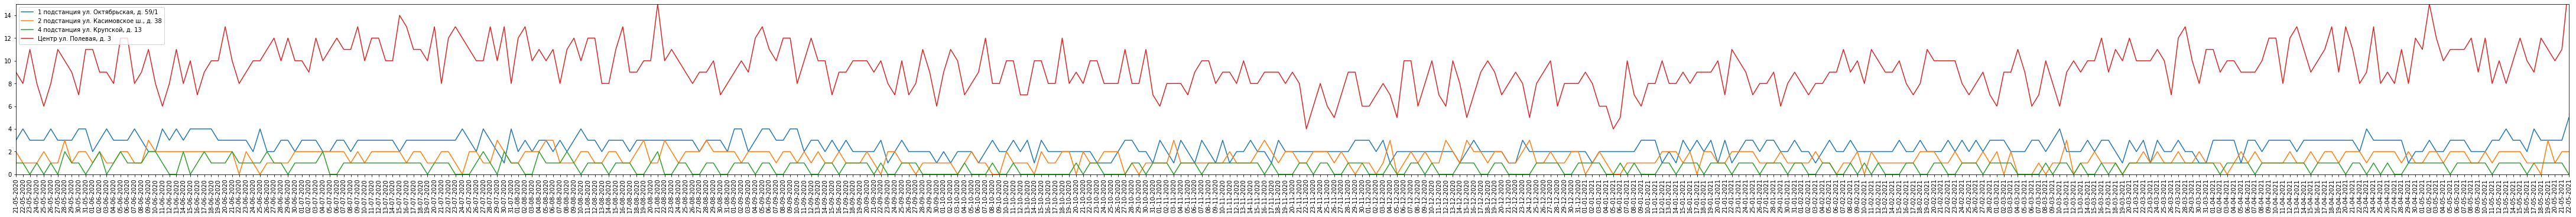

In [ ]:
fig = plt.figure()
axes = fig.add_axes([0, 0, 10, 1], xlim=(df_pivot.index[0], df_pivot.index[-1]), ylim=(0, 15), xticks=df_pivot.index)
axes.xaxis.set_major_formatter (pltd.DateFormatter("%d-%m-%Y"))
plt.xticks(rotation=90)
axes.plot(df_pivot.iloc[:, 0], label='1 подстанция ул. Октябрьская, д. 59/1')
axes.plot(df_pivot.iloc[:, 1], label='2 подстанция ул. Касимовское ш., д. 38')
axes.plot(df_pivot.iloc[:, 2], label='4 подстанция ул. Крупской, д. 13')
axes.plot(df_pivot.iloc[:, 3], label='Центр ул. Полевая, д. 3')
axes.legend(loc='upper left')